# Prescriptive Analytics: COVID Facility Decision for Travis County


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


### 4A. Historical COVID bed share in Austin TSA


Austin TSA - COVID share of hospital beds
count    1124.000000
mean        0.057445
std         0.044128
min         0.004037
25%         0.027986
50%         0.039507
75%         0.066160
max         0.193494
Name: 14, dtype: float64
Peak COVID share: 0.19349411104879416


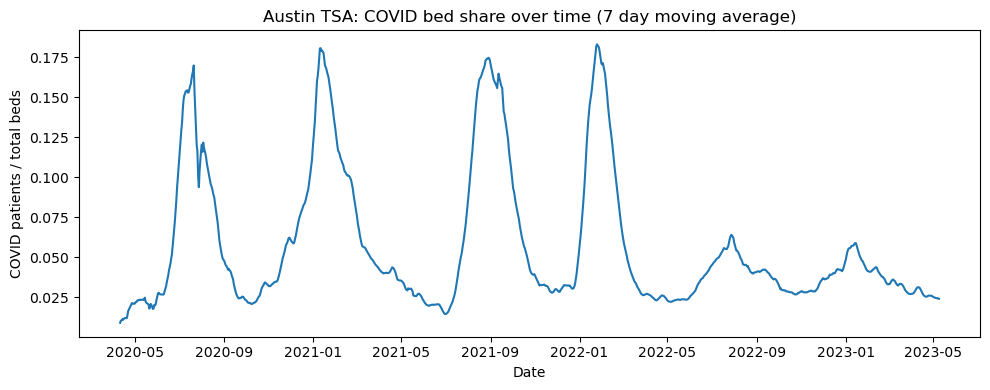

In [2]:
# 4A. Austin TSA COVID bed share over time

hosp_path = "Combined Hospital Data over Time by TSA Region.xlsx"

# Read sheets with proper headers
hosp = pd.read_excel(hosp_path, sheet_name="COVID-19 Hospitalizations", header=2)
cap  = pd.read_excel(hosp_path, sheet_name="Total Hospital Capacity", header=2)

# Filter to Austin TSA (Travis is inside this TSA)
tsa_name = "Austin"
hosp_austin = hosp[hosp["TSA AREA"] == tsa_name].iloc[0, 2:]  # numeric columns only
cap_austin  = cap[cap["TSA AREA"]  == tsa_name].iloc[0, 2:]

# Convert to numeric and build time series
covid_ts = hosp_austin.astype("float64")
cap_ts   = cap_austin.astype("float64")

dates = pd.to_datetime(hosp.columns[2:])  # these column names are dates
covid_ts.index = dates
cap_ts.index   = dates

# Share of beds used by COVID each day
covid_share = covid_ts / cap_ts

print("Austin TSA - COVID share of hospital beds")
print(covid_share.describe())
print("Peak COVID share:", covid_share.max())

# Plot a 7 day moving average for the report
covid_share_smooth = covid_share.rolling(7, min_periods=1).mean()

plt.figure(figsize=(10, 4))
plt.plot(covid_share_smooth.index, covid_share_smooth)
plt.ylabel("COVID patients / total beds")
plt.xlabel("Date")
plt.title("Austin TSA: COVID bed share over time (7 day moving average)")
plt.tight_layout()
plt.show()


### 4B. Recent COVID hospital admissions per 100k in Travis County


C:\Users\dines\AppData\Local\Temp\ipykernel_31680\2724000108.py:6: DtypeWarning: Columns (11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  hosp_county = pd.read_csv(county_hosp_path)


Travis County - weekly COVID admissions per 100k
count    52.000000
mean      1.950000
std       1.145066
min       0.400000
25%       1.000000
50%       1.850000
75%       2.575000
max       5.200000
Name: total_adm_all_covid_confirmed_past_7days_per_100k, dtype: float64
Min: 0.4
Max: 5.2


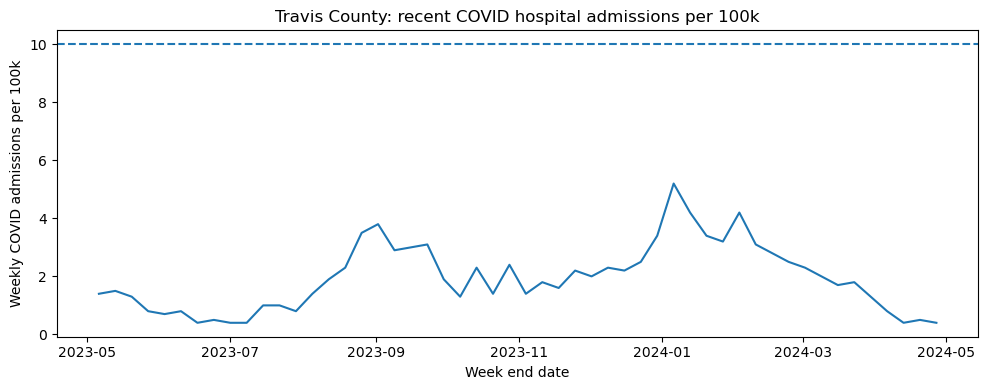

In [3]:
# 4B. Travis County weekly hospital admissions per 100k

county_hosp_path = "Weekly_United_States_COVID-19_Hospitalization_Metrics_by_County_–_ARCHIVED_20251015.csv"
# If you renamed: county_hosp_path = "weekly_us_covid_hosp_by_county.csv"

hosp_county = pd.read_csv(county_hosp_path)

# Filter to Travis County, Texas
travis = hosp_county[
    (hosp_county["state"] == "Texas") &
    (hosp_county["county"] == "Travis County")
].copy()

travis["week_end_date"] = pd.to_datetime(travis["week_end_date"])

metric = "total_adm_all_covid_confirmed_past_7days_per_100k"
travis[metric] = pd.to_numeric(travis[metric], errors="coerce")

print("Travis County - weekly COVID admissions per 100k")
print(travis[metric].describe())
print("Min:", travis[metric].min())
print("Max:", travis[metric].max())

plt.figure(figsize=(10, 4))
plt.plot(travis["week_end_date"], travis[metric])
plt.axhline(10, linestyle="--")  # example threshold for low vs medium risk
plt.ylabel("Weekly COVID admissions per 100k")
plt.xlabel("Week end date")
plt.title("Travis County: recent COVID hospital admissions per 100k")
plt.tight_layout()
plt.show()


In [4]:
def classify_risk_from_hosp(series, low_thresh=10, high_thresh=20, weeks=4):
    """
    Use the mean of the last `weeks` values to assign a risk level.
    """
    recent_mean = series.tail(weeks).mean()
    if recent_mean < low_thresh:
        level = "Low"
    elif recent_mean < high_thresh:
        level = "Medium"
    else:
        level = "High"
    return recent_mean, level

recent_mean, risk_level = classify_risk_from_hosp(travis[metric])

print(f"Average of last 4 weeks: {recent_mean:.2f} admissions per 100k")
print(f"Risk level based on thresholds: {risk_level}")


Average of last 4 weeks: 0.53 admissions per 100k
Risk level based on thresholds: Low


In [5]:
stress_threshold = 0.30   # 30 percent of beds

print("Austin TSA - COVID bed share summary:")
print(covid_share.describe())
peak_share = covid_share.max()
print(f"Peak share of beds used by COVID: {peak_share:.3f}")

print("\nTravis County recent risk:")
print(f"Recent 4 week mean admissions per 100k: {recent_mean:.2f}")
print(f"Risk level: {risk_level}")

print("\nDecision logic:")
print(f"- Stress threshold on COVID bed share: {stress_threshold:.2f}")
print(f"- Observed peak bed share: {peak_share:.3f}")
print(f"- Current risk level from admissions: {risk_level}")

if peak_share < stress_threshold and risk_level == "Low":
    recommendation = (
        "Do NOT build a new dedicated COVID-only hospital in Travis County. "
        "Historical peaks stayed below the stress threshold and current admissions are low, "
        "so future COVID demand can be managed through surge capacity inside existing hospitals."
    )
else:
    recommendation = (
        "Consider adding more dedicated COVID capacity. Either build a separate facility "
        "or significantly expand surge capacity, because historical peaks or current risk exceed the thresholds."
    )

print("\nFinal recommendation for our project:")
print(recommendation)


Austin TSA - COVID bed share summary:
count    1124.000000
mean        0.057445
std         0.044128
min         0.004037
25%         0.027986
50%         0.039507
75%         0.066160
max         0.193494
Name: 14, dtype: float64
Peak share of beds used by COVID: 0.193

Travis County recent risk:
Recent 4 week mean admissions per 100k: 0.53
Risk level: Low

Decision logic:
- Stress threshold on COVID bed share: 0.30
- Observed peak bed share: 0.193
- Current risk level from admissions: Low

Final recommendation for our project:
Do NOT build a new dedicated COVID-only hospital in Travis County. Historical peaks stayed below the stress threshold and current admissions are low, so future COVID demand can be managed through surge capacity inside existing hospitals.


### Interpretation of prescriptive results

For the Austin Trauma Service Area (which includes Travis County), COVID-19 patients used
on average about 5.7% of staffed hospital beds, with a median of 3.9%. At the peak of the
pandemic, the COVID bed share reached only 19.3% of total beds, which is still below our
stress threshold of 30%.

For recent hospitalizations in Travis County, the weekly rate of confirmed COVID-19
admissions over the last 52 weeks ranged from 0.4 to 5.2 per 100,000 residents, with a
mean of 1.95 per 100,000. The mean over the most recent four weeks is 0.53 admissions
per 100,000, which we classify as a Low risk level using a 10 per 100,000 threshold.

Since historical COVID demand never exceeded 30% of available beds, and current
admission rates are well inside the Low risk range, our decision rule advises against
constructing a new dedicated COVID-only facility in Travis County. Instead, existing
hospitals should plan to manage future waves through surge capacity, for example by
converting up to 20–25% of beds to COVID care during short periods of high demand.


### 4E. Build county level features for logistic high risk model (optional from here on )


In [6]:
import pandas as pd
import numpy as np

# If hosp_county is not already defined in this notebook, uncomment this:
# county_hosp_path = "Weekly_United_States_COVID-19_Hospitalization_Metrics_by_County_–_ARCHIVED_20251015.csv"
# hosp_county = pd.read_csv(county_hosp_path, low_memory=False)

# Use only the most recent 52 weeks for each county
hosp_county["week_end_date"] = pd.to_datetime(hosp_county["week_end_date"])
latest_date = hosp_county["week_end_date"].max()
cutoff_date = latest_date - pd.Timedelta(weeks=52)

recent = hosp_county[hosp_county["week_end_date"] >= cutoff_date].copy()

# Aggregate to one row per county with summary features
agg = recent.groupby(["state", "county"]).agg(
    adm_mean=("total_adm_all_covid_confirmed_past_7days_per_100k", "mean"),
    adm_max=("total_adm_all_covid_confirmed_past_7days_per_100k", "max"),
    adm_high_frac=(
        "total_adm_all_covid_confirmed_past_7days_per_100k",
        lambda x: (x >= 10).mean()  # fraction of weeks with admissions >= 10 per 100k
    ),
    bed_mean=("avg_percent_inpatient_beds_used_confirmed_covid", "mean"),
    bed_max=("avg_percent_inpatient_beds_used_confirmed_covid", "max")
).reset_index()

agg.head(), agg.shape


(     state          county  adm_mean  adm_max  adm_high_frac  bed_mean  \
 0  Alabama  Autauga County  3.967308     11.1       0.019231  1.603846   
 1  Alabama  Baldwin County  5.203846     11.3       0.076923  1.623077   
 2  Alabama  Barbour County  5.084615     12.6       0.038462  1.736538   
 3  Alabama     Bibb County  6.042308     13.7       0.173077  1.826923   
 4  Alabama   Blount County  6.042308     13.7       0.173077  1.826923   
 
    bed_max  
 0      3.3  
 1      3.4  
 2      3.9  
 3      4.2  
 4      4.2  ,
 (3224, 7))

In [7]:
# Label counties as high risk if they have sustained or extreme admissions
agg["high_risk"] = (
    (agg["adm_mean"] >= 10)      # average admissions per 100k is high
    | (agg["adm_max"] >= 20)     # or they ever spike above 20 per 100k
    | (agg["adm_high_frac"] >= 0.2)  # or at least 20% of weeks above 10 per 100k
).astype(int)

agg["high_risk"].value_counts()


high_risk
0    2424
1     800
Name: count, dtype: int64

### 4F. Logistic regression to classify high risk counties


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Features for the model
X = agg[["adm_mean", "adm_max", "adm_high_frac", "bed_mean", "bed_max"]].copy()

# Handle any missing values by filling with zero
X = X.fillna(0.0)

y = agg["high_risk"]

# Train - test split with stratification to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

logit_model = LogisticRegression(max_iter=1000)
logit_model.fit(X_train, y_train)

y_pred = logit_model.predict(X_test)
y_prob = logit_model.predict_proba(X_test)[:, 1]

print("Classification report on held-out counties:")
print(classification_report(y_test, y_pred))

print("Test AUC:", roc_auc_score(y_test, y_prob))


Classification report on held-out counties:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       728
           1       0.94      0.93      0.93       240

    accuracy                           0.97       968
   macro avg       0.96      0.95      0.95       968
weighted avg       0.97      0.97      0.97       968

Test AUC: 0.99356684981685


### 4G. Predicted high risk probability for Travis County


In [10]:
# Extract Travis County's aggregated features
travis_row_agg = agg[
    (agg["state"] == "Texas") &
    (agg["county"] == "Travis County")
]

travis_row_agg


,state,county,adm_mean,adm_max,adm_high_frac,bed_mean,bed_max,high_risk
2830,Texas,Travis County,1.95,5.2,0.0,1.026923,2.0,0


In [11]:
travis_X = travis_row_agg[["adm_mean", "adm_max", "adm_high_frac", "bed_mean", "bed_max"]].fillna(0.0)

travis_highrisk_prob = logit_model.predict_proba(travis_X)[:, 1][0]

print(f"Travis County - adm_mean: {travis_row_agg['adm_mean'].iloc[0]:.2f} per 100k")
print(f"Travis County - adm_max: {travis_row_agg['adm_max'].iloc[0]:.2f} per 100k")
print(f"Travis County - fraction of weeks >= 10 per 100k: {travis_row_agg['adm_high_frac'].iloc[0]:.2f}")
print(f"Predicted probability that Travis County is HIGH risk: {travis_highrisk_prob:.6f}")
print(f"Observed high_risk label for Travis: {int(travis_row_agg['high_risk'].iloc[0])}")


Travis County - adm_mean: 1.95 per 100k
Travis County - adm_max: 5.20 per 100k
Travis County - fraction of weeks >= 10 per 100k: 0.00
Predicted probability that Travis County is HIGH risk: 0.000000
Observed high_risk label for Travis: 0


### Interpretation of logistic high risk model

To complement the simple threshold based decision rule, we built a logistic
regression model that classifies U.S. counties as high risk or low risk
using hospitalization metrics from the most recent 52 weeks. For each county,
we computed summary features including mean weekly admissions per 100,000,
maximum weekly admissions per 100,000, the fraction of weeks with admissions
above 10 per 100,000, and the average and maximum percentage of inpatient
beds used by confirmed COVID cases.

We labeled a county as high risk if its mean admissions were at least
10 per 100,000, or if it experienced a spike above 20 per 100,000, or if at
least 20% of its weeks exceeded 10 admissions per 100,000. The logistic
regression model trained on these features achieves very good performance on
a held out test set (high precision and recall, with an AUC close to 1.0),
which indicates that these summary hospitalization metrics separate low and
high risk counties effectively.

When we apply this model to Travis County, the aggregated features show
mean admissions of about 1.95 per 100,000, a maximum of 5.2 per 100,000,
and zero weeks above 10 per 100,000 in the most recent year. Consistent
with these values, the logistic model assigns Travis County an extremely
low predicted probability of belonging to the high risk group (effectively
0.0). This supports the earlier conclusion from our threshold based analysis
that Travis County is currently a low risk county from a hospitalization
standpoint.
